In [82]:
import math
import re
import random

from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from datautils.vocabulary import Vocabulary

from tqdm import tqdm_notebook
import spacy

import six

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

## Constants

In [23]:
## CONSTANTS

class constants:
    TRUMP_TWEET_CSV = "/research/data/trump.csv"
    TRAIN_PROPORTION = 0.8
    WORD_START_TOKEN = "^"
    WORD_END_TOKEN= "_"

## Data

In [96]:
df = pd.read_csv(constants.TRUMP_TWEET_CSV)
df['tweet'] = df.tweet.apply(literal_eval)
df['tweet'] = df.tweet.apply(lambda x: [xx.lower() for xx in x])
df.tweet[0]

['if',
 'the',
 'press',
 'would',
 'cover',
 'me',
 'accurately',
 'honorably',
 'i',
 'would',
 'have',
 'far',
 'less',
 'reason',
 'to',
 'tweet',
 'sadly',
 'i',
 'dont',
 'know',
 'if',
 'that',
 'will',
 'ever',
 'happen']

In [321]:
class TrumpTweetDataset(object):
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.data['tweet'] = self.data.tweet.apply(literal_eval)
        self.data['tweet'] = self.data.tweet.apply(lambda tweet: [word.lower() for word in tweet])
        
    def get_data(self):
        return self.data.tweet.tolist()    

class TrumpTweetVectorizer(object):
    def __init__(self, word_vocab, max_seq_length):
        self.word_vocab = word_vocab
        self.max_seq_length = max_seq_length
        
    def save(self, filename):
        vec_dict = {"word_vocab": self.word_vocab.get_serializable_contents(),
                    'max_seq_length': self.max_seq_length}

        with open(filename, "w") as fp:
            json.dump(vec_dict, fp)
        
    @classmethod
    def load(cls, filename):
        with open(filename, "r") as fp:
            vec_dict = json.load(fp)

        vec_dict["word_vocab"] = Vocabulary.deserialize_from_contents(vec_dict["word_vocab"])
        return cls(**vec_dict)

    @classmethod
    def induce_from_text(cls, tweets):
        """
        """
        vocab = Vocabulary(use_unks=True,
                           use_start_end=True,
                           start_token=constants.WORD_START_TOKEN,
                           end_token=constants.WORD_END_TOKEN)
        max_seq_length = 0
        for tweet in tweets:
            vocab.add_many(tweet)
            if len(tweet) > max_seq_length:
                max_seq_length = len(tweet)
        max_seq_length = max_seq_length + 2
        return cls(vocab, max_seq_length)

    def convert_dataset(self, tweets):

        num_data = len(tweets)
        
        x_sequences = np.zeros((num_data, self.max_seq_length), dtype=np.int64)
        y_targets = np.zeros((num_data, self.max_seq_length), dtype=np.int64)

        for index, tweet in enumerate(tweets):
            converted = list(self.word_vocab.map(tweet, include_start_end=True))
            x_version = converted[:-1]
            y_version = converted[1:]
            
            x_sequences[index, :len(x_version)] = x_version
            y_targets[index, :len(y_version)] = y_version
            

        return VectorizedSingleIODataset(x_sequences, y_targets)

class VectorizedSingleIODataset(Dataset):
    def __init__(self, x_input, y_target):
        self.x_input = x_input
        self.y_target = y_target

    def __len__(self):
        return len(self.x_input)

    def __getitem__(self, index):
        return {'x_input': self.x_input[index],
                'y_target': self.y_target[index],
                'x_lengths': len(self.x_input[index].nonzero()[0])}
    
class DataServer(object):
    def __init__(self, vectorized_data):
        self.vectorized_data = vectorized_data
        self.gpu_mode = False
        self.volatile_mode = False
    
    def serve_batches(self, batch_size, num_batches=-1, num_workers=0):
        datagen = DataLoader(self.vectorized_data, batch_size=batch_size, 
                             shuffle=True, num_workers=num_workers)
        for batch_index, batch in enumerate(datagen):
            out = {}
            for key, val in batch.items():
                if not isinstance(val, Variable):
                    val = Variable(val)
                if self.gpu_mode:
                    val = val.cuda()
                if self.volatile_mode:
                    val = val.volatile() 
                out[key] = val
                
            yield out
            if num_batches > 0 and batch_index > num_batches:
                break
                
    def enable_gpu_mode(self):
        self.gpu_mode = True
        
    def disable_gpu_mode(self):
        self.gpu_mode = False

## Build Model

In [325]:
class TweetLanguageModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, input_vocab_size, num_rnn_layers=1):
        super(TweetLanguageModel, self).__init__()
        
        self.emb = nn.Embedding(input_vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=num_rnn_layers)
        self.affine = nn.Linear(hidden_dim, input_vocab_size)
        
        
        self._cached_config = dict(embedding_dim=embedding_dim, 
                                   hidden_dim=hidden_dim,
                                   input_vocab_size=input_vocab_size,
                                   num_rnn_layers=num_rnn_layers)
        
    def hidden_from_x(self, x, zero_out=True):
        hidden = x.data.new(self.rnn.num_layers, 
                                     x.size(0), 
                                     self.rnn.hidden_size)
        if zero_out:
            hidden = hidden.zero_()
        else:
            stdv = 1. / math.sqrt(self.hidden.size(2))
            hidden.data.uniform_(-stdv, stdv)
        
        return Variable(hidden)
    
    def forward(self, x_in, apply_softmax=False, hidden=None, return_with_hidden=False):
        x_embedded = self.emb(x_in)

        if hidden is None:
            hidden = self.hidden_from_x(x_embedded, True)
            
        x_post_rnn, hidden = self.rnn(x_embedded, hidden)
        x_post_rnn = x_post_rnn.contiguous()
        x_reshaped = x_post_rnn.view(-1, x_post_rnn.size(2))
        
        x_out = self.affine(x_reshaped)
        
        if apply_softmax:
            x_out = F.softmax(x_out)
        
        if return_with_hidden:
            return x_out, hidden
        else:
            return x_out
    
    def save(self, json_filename, model_state_filename):
        torch.save(self.state_dict(), model_state_filename)
        with open(json_filename, "w") as fp:
            json.dump(self._cached_config, fp)
    
    @classmethod
    def load(cls, json_filename, model_state_filename):
        with open(json_filename, "r") as fp:
            config = json.load(fp)
        out = cls(**config)
        state_dict = torch.load(model_state_filename)
        out.load_state_dict(state_dict)
        return out

In [195]:
def accuracy(yhat, ytrue):
        pred = yhat.max(1)[1].type_as(ytrue)
        correct = pred.eq(ytrue)
        if not hasattr(correct, 'mean'):
            correct = correct.cpu()
        return correct.float().mean()

In [365]:
def variable_from_tokens(vectorizer, tokens):
    out = np.array(list(vectorizer.word_vocab.map(tokens)))
    return Variable(torch.LongTensor(out)).view(1,-1)

def greedy_sample_from(model, vectorizer, temperature=1.0, seed_text=None, use_cuda=True, hx=None, n_length=10, burn=0):
    if seed_text is None:
        seed_text = [vectorizer.word_vocab.start_token]
    in_var = variable_from_tokens(vectorizer, seed_text)
    if use_cuda:
        in_var = in_var.cuda()
    for _ in range(n_length):
        if in_var.data.min() < 0:
            continue
        y_pred, hx = model(in_var, apply_softmax=False, hidden=hx, return_with_hidden=True)
        y_pred = torch.nn.functional.softmax(y_pred/temperature)
        in_var = torch.multinomial(y_pred)
        seed_text.append(vectorizer.word_vocab.lookup(in_var.data.cpu().numpy().ravel()[0]))
        if seed_text[-1] == constants.WORD_END_TOKEN:
            break
    return seed_text

In [335]:
class CrossEntTrainer(object):
    def __init__(self, model, optimizer_class, gpu_mode=False, learning_rate=0.001):
        self.model = model
        if isinstance(optimizer_class, six.string_types):
            if not hasattr(torch.optim, optimizer_class):
                raise Exception("{} is not a valid optimizer".format(optimizer_class))
            optimizer_class = getattr(torch.optim, optimizer_class)
        self.optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-7)
        self.loss = nn.CrossEntropyLoss()
        self.gpu_mode = gpu_mode
        self.loss_history = []
        self.accuracy_history = []
    
    def _reset_gradient(self):
        self.optimizer.zero_grad()
        self.model.zero_grad()
        
    def train(self, data_server, batch_size=64, num_batches=-1, num_epochs=1):
        
        if self.gpu_mode:
            self.model.cuda()
            data_server.enable_gpu_mode()
        else:
            self.model.cpu()
            data_server.disable_gpu_mode()
            
        epoch_bar = tqdm_notebook(total=num_epochs, unit=" epochs", position=0)
        batch_bar = tqdm_notebook(unit=" batches", position=1)
        
        for _ in range(num_epochs):
            for batch in data_server.serve_batches(batch_size, num_batches):
                
                self._reset_gradient()
                yhat = self.model(batch['x_input'])
                
                # best to reshape y_target to match the yhat
                yhat = yhat.view(-1, yhat.size(1))
                y_target = batch['y_target'].view(-1)
                computed_loss = self.loss(yhat, y_target)
                computed_loss.backward()
                self.optimizer.step()

                computed_loss_ = float(computed_loss.data.cpu().numpy()[0])
                computed_accuracy = accuracy(yhat, y_target).data.cpu().numpy()[0]
                
                batch_bar.set_postfix(loss=computed_loss_, accuracy=computed_accuracy)
                self.loss_history.append(computed_loss_)
                self.accuracy_history.append(computed_accuracy)
                batch_bar.update(1)
                
            sampled_text = greedy_sample_from(model, vectorizer, use_cuda=self.gpu_mode, n_length=10)
            epoch_bar.set_postfix(sample=sampled_text)
            epoch_bar.update(1)

        batch_bar.clear()

In [374]:
" ".join(greedy_sample_from(model, vectorizer, temperature=0.9, n_length=30)[1:])

'wendy realdonaldtrump bradcooney1wise the mr trump the art of the deal is doing is why _'

In [ ]:
text_dataset = TrumpTweetDataset(constants.TRUMP_TWEET_CSV)
tweet_sequences = text_dataset.get_data()

n_train = int(constants.TRAIN_PROPORTION * len(tweet_sequences))
train_tweets = tweet_sequences[:n_train]
eval_tweets = tweet_sequences[n_train:]

In [327]:
model_parameters = dict(embedding_dim=64, 
                        hidden_dim=256,
                        num_rnn_layers=1)

vectorizer_name = "trump_twitter_{hidden_dim}h_{embedding_dim}e.vectorizer".format(**model_parameters)
model_json_name = "trump_twitter_{hidden_dim}h_{embedding_dim}e.json".format(**model_parameters)
model_state_name = "trump_twitter_{hidden_dim}h_{embedding_dim}e.state".format(**model_parameters)

import os
if os.path.exists(vectorizer_name):
    vectorizer = TrumpTweetVectorizer.load(vectorizer_name)
    model = TweetLanguageModel.load(json_filename=model_json_name, model_state_filename=model_state_name)
    print("Sucessfully Loaded!")
else:
    vectorizer = TrumpTweetVectorizer.induce_from_text(tweet_sequences)
    model = TweetLanguageModel(input_vocab_size=len(vectorizer.word_vocab), **model_parameters)
    print("Successfully Created!")

Sucessfully Loaded!


In [328]:
vectorized_train_data = vectorizer.convert_dataset(train_tweets)
vectorized_eval_data = vectorizer.convert_dataset(eval_tweets)

train_server = DataServer(vectorized_train_data)
eval_server = DataServer(vectorized_eval_data)

In [329]:
trainer = CrossEntTrainer(model, "Adam", True, learning_rate=0.001)

In [330]:
try:
    trainer.train(train_server, num_epochs=3)
except KeyboardInterrupt:
    pass

In [331]:
vectorizer.save(vectorizer_name)
model.save(json_filename=model_json_name, model_state_filename=model_state_name)

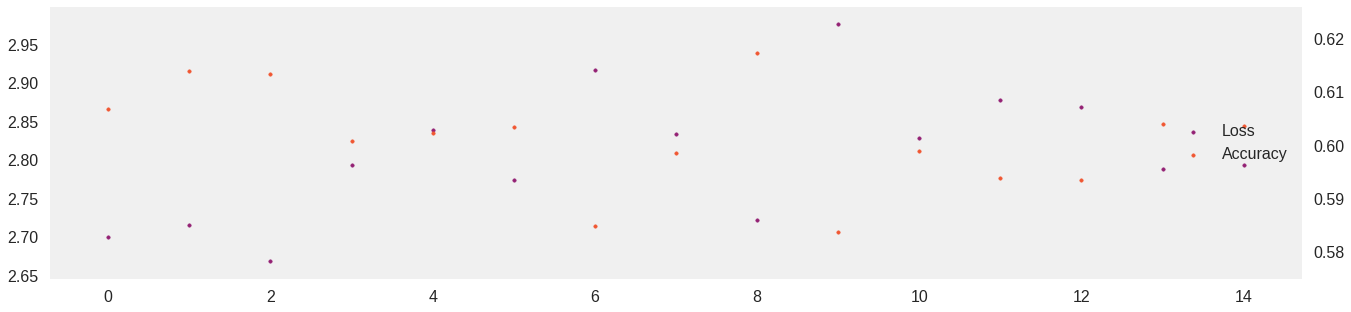

In [332]:
sns.set_context("poster")
sns.set_style("dark", {'axes.facecolor':'0.94'})

average_step = 5

_, ax = plt.subplots(1, 1, figsize=(20,5))

loss_history = trainer.loss_history[:len(trainer.loss_history)//average_step*average_step]
acc_history = trainer.accuracy_history[:len(trainer.accuracy_history)//average_step*average_step]

loss_history = np.array(loss_history).reshape(-1, average_step).mean(axis=-1)
acc_history = np.array(acc_history).reshape(-1, average_step).mean(axis=-1)


loss_artist = ax.scatter(np.arange(len(loss_history)), 
                         loss_history, color='#942174', 
                         s=10+average_step//2, label="Loss");

ax2 = ax.twinx()
acc_artist = ax2.scatter(np.arange(len(acc_history)), 
                         acc_history, color='#F05732', 
                         s=10+average_step//2, label="Accuracy");
artists = [loss_artist, acc_artist]
labels = [artist.get_label() for artist in artists]
plt.legend(artists, labels, loc=5)
